### Notes

* predict bispectral index (BIS): depth of anesthesia (BIS values range from 0 to 100. A value of 0 represents the absence of brain activity, and 100 represents the awake state. BIS values between 40 to 60 represent adequate general anesthesia for a surgery, values less than 40 represent a deep hypnotic state. BIS value is usually maintained between 40 to 60 to prevent awareness under anesthesia.) -- track_name = [BIS/BIS]
* Predict MINS (Myocardial injury after noncardiac surgery) which is defined by elevated postoperative cardiac troponin concentrations that exceed the 99th percentile of the upper reference limit of the assay

In [1]:
# standard libs
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

# modeliing libs
import tensorflow as tf
from sklearn.svm import SVR
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold

In [2]:
# import data
dataFile = r'C:\Users\ta1031742\OneDrive - Bose Corporation\Documents\Admin\Northeastern\DS5500-Capstone\Data\vitaldb\vitaldb-a-high-fidelity-multi-parameter-vital-signs-database-in-surgical-patients-1.0.0\clinical_data.csv'

data = pd.read_csv(dataFile)

print(data.shape)
data.head()

(6388, 74)


,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,...,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,...,0,120,0.0,100,70,0,10,0,0,0
1,2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,...,0,150,0.0,0,100,0,20,0,0,0
2,3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,...,0,0,0.0,0,50,0,0,0,0,0
3,4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,...,0,80,0.0,100,100,0,50,0,0,0
4,5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,...,0,0,0.0,0,160,0,10,900,0,2100


In [3]:
# create anedur variable
data['anedur'] = (data['aneend'] - data['anestart']).astype(int)

In [4]:
# column names
# data.columns.to_list()

In [104]:
# anesthesia duration

# stats
print(data['anedur'].mean())
print(data['anedur'].median())
print(data['anedur'].std())
print(data['anedur'].max())
print(data['anedur'].min()); print()

# stats
print(np.log(data['anedur']).mean())
print(np.log(data['anedur']).median())
print(np.log(data['anedur']).std())
print(np.log(data['anedur']).max())
print(np.log(data['anedur']).min())

11978.44919367465
10500.0
6897.910059268698
111600
960

9.237186729120126
9.259130536145614
0.5615160711648495
11.622676328929348
6.866933284461882


### Anesthesia Duration

In [60]:
# get data
# df = data[['age', 'sex', 'height', 'weight', 'bmi', 'asa', 'anedur']]
# df = data[['age', 'sex', 'height', 'weight', 'bmi', 'asa', 'optype', 'approach', 'position', 'ane_type', 'preop_ecg', 'preop_htn', 'preop_dm', 'preop_pft', 'anedur']]
df = data[['age', 'sex', 'height', 'weight', 'bmi', 'asa', 'optype', # 'dx', 
           'opname', 'department', 'approach', 'position', 
           'ane_type', 'preop_ecg', 'preop_htn', 'preop_dm', 'preop_pft', 'preop_hb', 'preop_plt', 'preop_pt', 
           'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 
           'preop_bun', 'preop_cr', 'cormack', 'airway', 'tubesize', 'iv1', 'aline1', 'anedur']]

print(df.shape)
df.head()

(6388, 34)


,age,sex,height,weight,bmi,asa,optype,opname,department,approach,...,preop_ast,preop_alt,preop_bun,preop_cr,cormack,airway,tubesize,iv1,aline1,anedur
0,77,M,160.2,67.5,26.3,2.0,Colorectal,Low anterior resection,General surgery,Open,...,18.0,16.0,10.0,0.82,I,Oral,7.5,Right forearm,Left radial,11400
1,54,M,167.3,54.8,19.6,2.0,Stomach,Subtotal gastrectomy,General surgery,Open,...,18.0,15.0,14.0,0.86,I,Oral,7.5,Left forearm,NaN,15960
2,62,M,169.1,69.7,24.4,1.0,Biliary/Pancreas,Cholecystectomy,General surgery,Videoscopic,...,17.0,34.0,14.0,1.18,I,Oral,7.5,Left forearm,NaN,4800
3,74,M,160.6,53.0,20.5,2.0,Stomach,Distal gastrectomy,General surgery,Videoscopic,...,23.0,18.0,10.0,0.96,I,Oral,NaN,Left forearm,Right radial,21000
4,66,M,171.0,59.7,20.4,3.0,Vascular,Aneurysmal repair,General surgery,Open,...,765.0,77.0,50.0,4.43,I,Oral,7.5,Right forearm,Right radial,23400


In [61]:
print('initial shape: ', df.shape); print()

# -------------------------------
# drop negative duration value
# -------------------------------

# get index of negative value
idx = np.where(data['anedur'] < 0)[0][0]

# drop index and check shape
df = df.drop(index=idx)
print('drop negative durations: ', df.shape); print()

# ----------------------
# handle age column
# ----------------------

# drop rows with '>89' in age column
print('>89: ', df[df['age']=='>89'].index.values)
idx = df[df['age']=='>89'].index.values
df = df.drop(index=idx).reset_index(drop=True)
print('drop >89 values: ', df.shape); print()

# drop rows with decimals in age column
print('decimals: ', df[~df['age'].str.isdecimal()].index.values)
idx = df[~df['age'].str.isdecimal()].index.values
df = df.drop(index=idx).reset_index(drop=True)
print('drop decimal values: ', df.shape); print()

# ------------------------
# replace gender values
# ------------------------

df['sex'] = df['sex'].replace(to_replace={'M': 0, 'F': 1})

# -----------------------------
# convert preop_ecg to binary
# -----------------------------

df.loc[df['preop_ecg'] == 'Normal Sinus Rhythm', 'preop_ecg'] = 0
df.loc[df['preop_ecg'] != 0, 'preop_ecg'] = 1

# -----------------------------
# ordinal encode cormacks
# -----------------------------

enc = OrdinalEncoder()
df['cormack'] = enc.fit_transform(df['cormack'].values.reshape(-1,1))


# ----------------
# missing values
# ----------------

# check for missing values
print('missing values: ')
print(df.isnull().sum()); print()

# drop rows with any missing values
# df = df.dropna(how='any').reset_index(drop=True)
df = df.fillna(value=-999)

print('fill missing values: ', df.shape); print()

# --------------------------------
# one-hot encode cat variables
# --------------------------------

non_dummy_cols = ['age', 'sex', 'height','weight', 'bmi', 'asa', 'preop_ecg', 'preop_htn', 'preop_dm', 'preop_hb', 
                  'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 
                  'preop_alt', 'preop_bun', 'preop_cr', 'cormack', 'anedur'] 

dummy_cols = list(set(df.columns) - set(non_dummy_cols))
df = pd.get_dummies(df, columns=dummy_cols)

print('final shape: ', df.shape)
df.head()

initial shape:  (6388, 34)

drop negative durations:  (6387, 34)

>89:  [1095 2431 2604 2921 3613 4554 4606 5396]
drop >89 values:  (6379, 34)

decimals:  [ 263  279  365 2318 3225 3481 4638 4869 5493 6327]
drop decimal values:  (6369, 34)

missing values: 
age              0
sex              0
height           0
weight           0
bmi              0
asa            132
optype           0
opname           0
department       0
approach         0
position       194
ane_type         0
preop_ecg        0
preop_htn        0
preop_dm         0
preop_pft        0
preop_hb       340
preop_plt      340
preop_pt       389
preop_aptt     401
preop_na       621
preop_k        619
preop_gluc     377
preop_alb      371
preop_ast      365
preop_alt      363
preop_bun      364
preop_cr       371
cormack        828
airway         411
tubesize      1465
iv1             71
aline1        2924
anedur           0
dtype: int64

fill missing values:  (6369, 34)

final shape:  (6369, 343)


,age,sex,height,weight,bmi,asa,preop_ecg,preop_htn,preop_dm,preop_hb,...,airway_Tracheostomy,preop_pft_Borderline obstructive,preop_pft_Mild obstructive,preop_pft_Mild restrictive,preop_pft_Mixed or pure obstructive,preop_pft_Moderate obstructive,preop_pft_Moderate restrictive,preop_pft_Normal,preop_pft_Severe obstructive,preop_pft_Severe restrictive
0,77,0,160.2,67.5,26.3,2.0,0,1,0,14.1,...,0,0,0,0,0,0,0,1,0,0
1,54,0,167.3,54.8,19.6,2.0,0,0,0,10.2,...,0,0,0,0,0,0,0,1,0,0
2,62,0,169.1,69.7,24.4,1.0,0,0,0,14.2,...,0,0,0,0,0,0,0,1,0,0
3,74,0,160.6,53.0,20.5,2.0,0,1,0,14.4,...,0,0,0,0,0,0,0,1,0,0
4,66,0,171.0,59.7,20.4,3.0,1,1,0,10.1,...,0,0,0,0,0,0,0,1,0,0


In [66]:
# ----------------------
# baseline model
# ----------------------

# take log to help with skewed data
y = np.log(df['anedur'])
# y = df['anedur']
X = df.drop(columns=['anedur'])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train
# model = LinearRegression()
# model = Ridge(alpha=0.01) # r2 = 0.617, mse = 0.122, rmse = 0.355
model = Lasso(alpha=0.001) # (0.001) r2 = 0.650, mse = 0.112, rmse = 0.335
# model = SVR(gamma='scale') # r2 = 0.614, mse = 0.124, rmse = 0.352
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# R2 score
print('R^2 score: ', model.score(X_test, y_test))

# MSE
print('MSE: ', mean_squared_error(y_test, y_pred))

# RMSE
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

R^2 score:  0.6513725152247292
MSE:  0.11178186597724848
RMSE:  0.3343379517453089


Text(0, 0.5, 'Predicted Values (log(duration))')

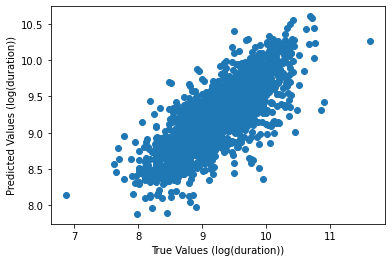

In [7]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values (log(duration))')
plt.ylabel('Predicted Values (log(duration))')

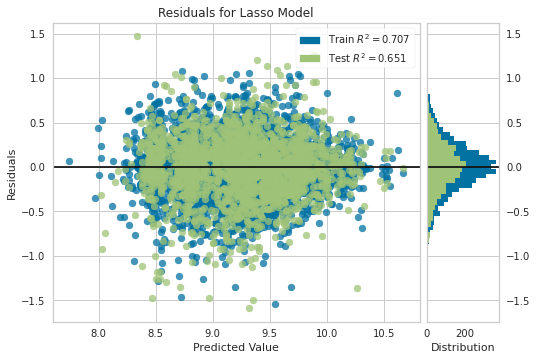

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [63]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [67]:
# number of zero coefficients
arr = model.coef_
arr.size - np.count_nonzero(arr)

68

In [68]:
idx = np.where(model.coef_ == 0)[0].tolist()
cols = X.columns.tolist()
[cols[i] for i in idx]

['bmi',
 'preop_dm',
 'preop_aptt',
 'preop_na',
 'preop_alb',
 'preop_cr',
 'approach_Videoscopic',
 'optype_Vascular',
 'opname_Anterior resection',
 'opname_Aortofemoral bypass',
 'opname_Arteriovenous fistula thrombectomy',
 'opname_Breast reconstruction',
 'opname_Breast-conserving surgery',
 'opname_Cecectomy',
 'opname_Central pancreatectomy',
 'opname_Cervical esophagostomy',
 'opname_Closure of bronchopleural fistula',
 'opname_Diagnostic pelviscopy',
 'opname_Electrocauterization',
 'opname_Enucleation of esophageal tumor',
 'opname_Exploration of wound',
 'opname_Gastric bypass',
 'opname_Ileocolectomy',
 'opname_Ilioiliac bypass',
 'opname_Incision of rectal stricture',
 'opname_Inguinal hernia',
 'opname_Internal mammary lymph node dissection',
 'opname_Intra-abdominal arterial bypass graft',
 'opname_Kidney transplantation',
 'opname_Ligation and stripping',
 'opname_Lung segmentectomy',
 'opname_Marsupialization',
 'opname_Nephroureterectomy',
 'opname_Ovarian cancer sta

In [59]:
data['dx'].value_counts()

Early gastric cancer                                   252
Colon cancer, sigmoid                                  207
Rectal cancer                                          169
Lung cancer right                                      166
Hepatocellular carcinoma                               154
                                                      ... 
Aspergilloma                                             1
Undifferentiated pleomorphic sarcoma of upper limb       1
Hepatoblastoma                                           1
Keloid scar                                              1
Colon submucosal tumor, unknown behavior                 1
Name: dx, Length: 1038, dtype: int64

In [64]:
# --------------------
# Dense NN
# --------------------

from tensorflow.keras import Sequential, Input
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping

# take log to help with skewed data
y = np.log(df['anedur'])
# y = df['anedur']
X = df.drop(columns=['anedur'])

# train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# build model - mse = 0.145, rmse = 0.381 (layers: 16, 8, 4, 2, 1)
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
# model.add(layers.Dense(32, activation='tanh'))
model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1))

# model = Sequential()
# model.add(Input(shape=(X_train.shape[1],)))
# model.add(layers.Dense(512, activation="relu"))
# model.add(layers.Dense(256, activation="relu"))
# model.add(layers.Dense(128, activation="relu"))
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dense(8, activation='relu'))
# model.add(layers.Dense(4, activation='relu'))
# model.add(layers.Dense(2, activation='relu'))
# model.add(layers.Dense(1))

# compile
model.compile(optimizer=Adam(learning_rate=0.05), 
              loss='mean_squared_error')

print(model.summary())


# fit
history = model.fit(X_train, 
                    y_train,
                    validation_split=0.2,
                    epochs=100, 
                    callbacks=EarlyStopping(monitor='loss', patience=10)
                   )

# predict
y_pred = model.predict(X_test)

# R2 score
# print('R^2 score: ', r2_score(y_test, y_pred))
# print('R^2 score: ', np.mean(r2_scores))

# MSE
print('MSE: ', mean_squared_error(y_test, y_pred))
# print('MSE: ', np.mean(mse_scores))

# RMSE
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
# print('RMSE: ', np.mean(rmse_scores))


# things tried: 
# 100 epochs with early stopping
# number of layers/neurons (1024)
# activation functions (relu, tanh)
# regularization techniques (dropout, batch normalization)
# optimizers (Adam, RMSProp, Adagrad)
# optimizer learning rate (0.001 - overfitting, 0.01 - overfitting, 0.05, 0.1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                5488      
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 4)                 36        
                                                                 
 dense_13 (Dense)            (None, 2)                 10        
                                                                 
 dense_14 (Dense)            (None, 1)                 3         
                                                                 
Total params: 5,673
Trainable params: 5,673
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
128/128 [==========================

In [14]:
# r2 = 0.547, mse = 0.145, rmse = 0.381

[-0.0006353762219741821,
 -0.015415832463202994,
 -0.004898559199756791,
 -0.012510944429823478,
 -0.0004939035229678534,
 -0.04073508919663782,
 -0.010068949292643792,
 -0.010283698371644334,
 -0.008388664037785043,
 -6.15313186602684e-05]

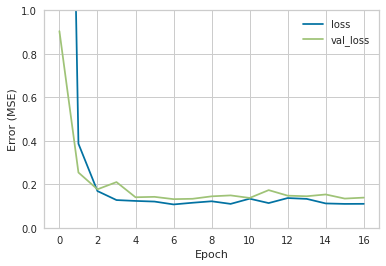

In [65]:
# plot predictions

import matplotlib.pyplot as plt


font = {# 'family' : 'normal',
        'weight' : 'normal',
        'size'   : 42}

plt.rc('font', **font)

# plot loss
def plot_loss(history):
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error (MSE)')
    plt.legend()
    plt.grid(True)
    
    
plot_loss(history)

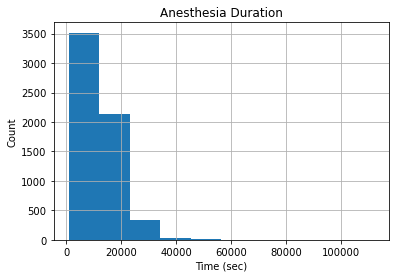

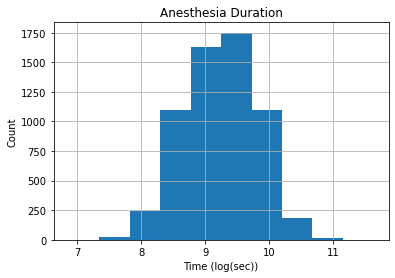

In [136]:
pd.to_numeric(df['anedur']).hist()
plt.xlabel('Time (sec)');
plt.ylabel('Count');
plt.title('Anesthesia Duration');
plt.show()

pd.to_numeric(np.log(df['anedur'])).hist()
plt.xlabel('Time (log(sec))');
plt.ylabel('Count');
plt.title('Anesthesia Duration');
plt.show()

# plt.hist(np.log(data['anedur']))

Things to try:

1. Use all "preop" variables
2. Implement Fully Connected NN
3. Evaluate feature importances (mutual information)
3. Implement RNN / LSTM
4. Include lab result variables
5. Research Transformers / Encoder / Decoder / Discriminator

### BIS Eval